# Import Libraries

In [182]:
import os,sys,re,glob,ipykernel,tweepy,stockmarket,nltk,collections,itertools,pandas as pd,numpy as np,\
        seaborn as sns, yfinance as yf, matplotlib.pyplot as plt, statsmodels.formula.api as smf,\
        statsmodels.api as sm, autoreload, importlib
from pathlib import Path
from string import punctuation 
from datetime import date
from sklearn.model_selection import train_test_split
np.random.seed(0)
pd.set_option('display.max_columns', None)

## Set Working Directory: 
    
* /Sentiment_Analysis 
    
* __ file __ isn't available in jupyter notebooks

    

In [2]:
file = os.getcwd().split(os.sep)
while(file[-1] != 'Sentiment_Analysis'): # Check the working directory
    os.chdir('..')
    file = os.getcwd().split(os.sep)
    sys.path.append(os.path.abspath(os.getcwd()))
print(f"root directory: {os.getcwd()}", sep = '\n')

root directory: c:\Code\Public_Github\Sentiment_Analysis


## Tweepy Custom Functions

In [3]:

from src import user_download_helper, user_download, merge_files, merge_all, \
    strip_all_words, sentence_word_probability

# Twitter API Credentials

In [4]:
# Read in keys from a csv file
autentication_path = os.path.abspath('../Sentiment_Analysis/Stock_Market/authentication/authentication_tokens.csv')
readin_authentication = pd.read_csv(autentication_path, header=0, sep=',')

consumer_key = readin_authentication['consumer_key'][0]
consumer_secret = readin_authentication['consumer_secret'][0]
access_token = readin_authentication['access_token'][0]
access_token_secret = readin_authentication['access_token_secret'][0]
bearer_token = readin_authentication['beaker_token'][0]

# connect to twitter application 
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
redirect_url = auth.get_authorization_url()
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit = True)

# Twitter Usernames

    Note:
    * Unvarified user's are not a problem, no one user can have the same ID
    * 'DayTradeWarrior' account was removed because twitter account was removed

In [5]:
# list of twitter usernames @user
long_term = ['jimcramer','KennethLFisher','AswathDamodaran',\
            'cstewartcfa','lei_zhang_lz', 'realwillmeade',\
                'RayDalio', 'GRDecter', 'BobPisani', 'BobPisani',\
                   'andrewrsorkin',  'EconguyRosie']
short_term = ['DanZanger', 'prrobbins', 'markminervini', 'bsc_daily',\
                'MITickWatcher', 'OptionsProVol', 'script_crypto',\
                'MarketMagnifier', 'TwentyonTwenty_', 'WatcherGuru',\
                'DipFinding','MacroCharts','techbudsolution',\
                'eWhispers', 'HindenburgRes', 'JehoshaphatRsch','ResearchGrizzly',\
                'biancoresearch', 'muddywatersre'
                ]

### WARNING ~ 10 minutes
    If previously loaded SKIP to CHECKPOINT 
    * Download User tweets into csv spreadsheets 

- ( Tweepy limit of 3200 tweets per user )


    

In [8]:
user_download(api, short_term, 'twitter_short_term_analysts') 

DanZanger prrobbins markminervini bsc_daily MITickWatcher OptionsProVol script_crypto MarketMagnifier TwentyonTwenty_ WatcherGuru DipFinding MacroCharts techbudsolution eWhispers HindenburgRes JehoshaphatRsch ResearchGrizzly biancoresearch muddywatersre 

In [9]:
user_download(api, long_term, 'twitter_long_term_analysts') # No problem with unvarified user's, no one user can have the same ID

jimcramer KennethLFisher AswathDamodaran cstewartcfa lei_zhang_lz realwillmeade RayDalio GRDecter BobPisani BobPisani andrewrsorkin EconguyRosie 

### Merge groups of users and save csv files

In [45]:
df_short_term = merge_files('twitter_short_term_analysts', display = 0)
df_long_term = merge_files('twitter_long_term_analysts', display = 0)
df_all = merge_all('merge/merged_twitter_analysts', display = 0)

size of merged data sets of twitter_short_term_analysts: (45487, 7)
size of merged data sets of twitter_long_term_analysts: (29251, 7)
size of merged data sets of merged_twitter_analysts: (74738, 7)


In [46]:
df_all.head(2)

,id,created_at,user,favorite_count,retweet_count,url,text
0,1618369736299122696,2023-01-25 22:06:27+00:00,WatcherGuru_twitter,1350,236,https://twitter.com/i/web/status/1618369736299...,JUST IN Facebook amp Instagram have reinstated...
1,1618359920109424641,2023-01-25 21:27:27+00:00,WatcherGuru_twitter,5000,817,https://twitter.com/i/web/status/1618359920109...,JUST IN Tesla reveals none of their 245553000 ...


In [47]:
print(df_all.info(verbose = True, null_counts = None, show_counts=None))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74738 entries, 0 to 29250
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              74738 non-null  int64              
 1   created_at      74738 non-null  datetime64[ns, UTC]
 2   user            74738 non-null  object             
 3   favorite_count  74738 non-null  int64              
 4   retweet_count   74738 non-null  int64              
 5   url             74738 non-null  object             
 6   text            72934 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 4.6+ MB
None


In [48]:
# Adding nonessential twitter words to remove
stop = nltk.corpus.stopwords.words("english") 
twitter_nonessential_words = ['twitter', 'birds','lists','list', 'source','just','am','pm'\
                              'a','b','c','d','e','f','g','h','i','j','k','l','m','n',\
                              'n','o','p','q','r','s','t','u','v','w','x','y','z']
stop.extend(twitter_nonessential_words) # merge two lists together
stop = sorted(list( dict.fromkeys(stop) )) # remove duplicates

### Create dictionarys of words 
    Total and individual tweet dictionaries
* Remove unnecessary words
* Generate frequency of words per sentence
* Too many to store as a csv

In [49]:
df_all_words = strip_all_words(df_all, stop)
df_all_words_count = df_all_words.explode().replace("", np.nan,regex=True).dropna() # drop NAN's and empty words
all_count = df_all_words_count.value_counts()

In [50]:
print(f"Tweets of Dictionaries: {len(df_all_words)}")
print(f"all words: {len(df_all_words_count)}")
print(f"Dictionary of all words: {len(all_count)}")

Tweets of Dictionaries: 74738
all words: 1062708
Dictionary of all words: 46150


In [51]:
print(f"5 words from dictionary of all words:\n{all_count[0:5]}", end='\n\n')

5 words from dictionary of all words:
stocks    9315
stock     9141
today     6131
market    5951
score     5718
Name: text, dtype: int64



In [52]:
print(f"All the words in each individual Sentence:\n{df_all_words[0:4]}")

All the words in each individual Sentence:
0    [, facebook, amp, instagram, reinstated, forme...
1            [, tesla, reveals, none, bitcoin, sold, ]
2                                                  NaN
3    [yesterday, us, government, filed, antitrust, ...
Name: text, dtype: object


    Note the [','] and 'NaN' variables
* Nan is a placeholder for tweets w/ images
* [','] are words removed with special cases

# Probability small example

d{  hat:1, sandwich:2, lemon:1, orange:1, snorkle:1 }

n = LEN(d.KEYS())  -> n = 5

p = sum(word in word) / ((word count) * 100) / (all words count)

Tweet1: hat sandwich lemon 

Tweet2: snorkle sandwich orange 

Tweet1:

-> 1/1 * 100 + 1/2 * 100 + 1/1 * 100   
-> 100 + 50 + 100 = 250
-> 250/5 = 50%

Tweet2:

-> 1/1 * 100 + 1/2 * 100 + 1/1 * 100 
-> 100 + 50 + 100 
-> 250/5 = 50%

p = (#  of particular words in sentence) / count(total # of particular word) * 100 / len(# of all types of words)

## Probability of individual tweets

In [53]:
# Probabilities
sentence_list, total_probability, individual_probability = sentence_word_probability(all_count, df_all_words)
print(f'sum of probability column = {sum(total_probability)}')

sum of probability column = 99.99999999999865


In [54]:
df_all_prob = df_all.reset_index()
df_all_prob['frequency'] = sentence_list
df_all_prob['probability'] = total_probability
df_all_prob = df_all_prob.dropna()
df_all_prob.insert(loc = 0, column = 'date', value = pd.to_datetime(df_all_prob['created_at']).dt.date.astype('datetime64[ns]'))
df_all_prob = df_all_prob.sort_values(by=['date'], ascending=False).drop(columns=['index'])

In [55]:
df_all_prob.head(2)

,date,id,created_at,user,favorite_count,retweet_count,url,text,frequency,probability
0,2023-01-25,1618369736299122696,2023-01-25 22:06:27+00:00,WatcherGuru_twitter,1350,236,https://twitter.com/i/web/status/1618369736299...,JUST IN Facebook amp Instagram have reinstated...,"[{'facebook': 0.9345794392523363, 'amp': 0.022...",0.000818
33715,2023-01-25,1618304573042483211,2023-01-25 17:47:31+00:00,DipFinding_twitter,0,0,https://twitter.com/i/web/status/1618304573042...,GMBL down 1285 at 01621 Volume 179M AvgVolume ...,"[{'gmbl': 1.5151515151515151, 'volume': 0.0292...",0.000035


In [56]:
df_wide1 = df_all_prob.pivot_table(index='date', values=['favorite_count','retweet_count'], aggfunc='sum',fill_value=0 ).sort_values(by='date',ascending=False)
df_wide2 = df_all_prob.pivot_table(index='date', columns=['user'], values=['probability'], aggfunc='sum',fill_value=0 ).sort_values(by='date',ascending=False).droplevel(0, axis=1) 
df_wide = pd.merge(df_wide1, df_wide2, how='inner', on='date')
df_wide.head(5)

,favorite_count,retweet_count,AswathDamodaran_twitter,BobPisani_twitter,DanZanger_twitter,DipFinding_twitter,EconguyRosie_twitter,GRDecter_twitter,HindenburgRes_twitter,JehoshaphatRsch_twitter,KennethLFisher_twitter,MITickWatcher_twitter,MacroCharts_twitter,MarketMagnifier_twitter,OptionsProVol_twitter,RayDalio_twitter,ResearchGrizzly_twitter,TwentyonTwenty__twitter,WatcherGuru_twitter,andrewrsorkin_twitter,biancoresearch_twitter,bsc_daily_twitter,cstewartcfa_twitter,eWhispers_twitter,jimcramer_twitter,lei_zhang_lz_twitter,markminervini_twitter,muddywatersre_twitter,prrobbins_twitter,realwillmeade_twitter,script_crypto_twitter,techbudsolution_twitter
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-25,143003,35508,0.000000,0.023801,0.000000,0.175004,0.000000,0.016972,0.205643,0.0,0.004014,0.328191,0.000000,0.0,0.017695,0.003379,0.0,0.029014,0.005072,0.0,0.026319,0.008576,0.003012,0.015153,0.026213,0.000000,0.001915,0.000038,0.000099,0.013486,0.005578,0.001190
2023-01-24,150712,24332,0.000000,0.006538,0.000873,0.120800,0.004202,0.018760,0.000137,0.0,0.006779,0.240603,0.000000,0.0,0.018561,0.002323,0.0,0.035258,0.007274,0.0,0.005369,0.014628,0.005385,0.031126,0.006297,0.002229,0.000000,0.001485,0.002862,0.001976,0.003061,0.004647
2023-01-23,222524,30789,0.000000,0.008851,0.000240,0.124214,0.002406,0.019534,0.000000,0.0,0.009772,0.204588,0.000000,0.0,0.012661,0.007285,0.0,0.040012,0.007718,0.0,0.033911,0.018032,0.000000,0.006881,0.006796,0.000000,0.000438,0.002091,0.003100,0.065572,0.001907,0.000000
2023-01-22,97111,12644,0.010341,0.000000,0.000000,0.000000,0.000000,0.009526,0.000000,0.0,0.000032,0.015234,0.000000,0.0,0.000000,0.002209,0.0,0.045780,0.000072,0.0,0.000000,0.045719,0.000000,0.006003,0.000068,0.000000,0.000052,0.000536,0.006668,0.000000,0.006352,0.000000
2023-01-21,57677,8814,0.000000,0.000000,0.000000,0.002720,0.000000,0.002672,0.000000,0.0,0.000176,0.013011,0.000631,0.0,0.000000,0.007970,0.0,0.039714,0.000443,0.0,0.012699,0.002508,0.002406,0.001243,0.000000,0.000456,0.000671,0.000000,0.000982,0.000000,0.000000,0.000000


    Could either leave weekends blank or fill with previous close
- resample('D').ffill()

In [57]:
# downloding index fund's or stock tickers
how_far_back = '2008-01-01'
today = date.today()
SandP_500_df = yf.download('^GSPC', how_far_back, today, interval = '1d')#.resample('D').ffill()
NASDAQ_df = yf.download('^IXIC', how_far_back, today, interval = '1d')#.resample('D').ffill()
DOW_JONES_df = yf.download('^DJI', how_far_back, today, interval = '1d')#.resample('D').ffill()
RUSSEL_df = yf.download('^RUT', how_far_back, today, interval = '1d')#.resample('D').ffill()
print(f'today: {today} -> to {how_far_back}')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
today: 2023-01-25 -> to 2008-01-01


In [59]:
SandP_500_df.head(7)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,1467.969971,1471.770020,1442.069946,1447.160034,1447.160034,3452650000
2008-01-03,1447.550049,1456.800049,1443.729980,1447.160034,1447.160034,3429500000
2008-01-04,1444.010010,1444.010010,1411.189941,1411.630005,1411.630005,4166000000
2008-01-07,1414.069946,1423.869995,1403.449951,1416.180054,1416.180054,4221260000
2008-01-08,1415.709961,1430.280029,1388.300049,1390.189941,1390.189941,4705390000
2008-01-09,1390.250000,1409.189941,1378.699951,1409.130005,1409.130005,5351030000
2008-01-10,1406.780029,1429.089966,1395.310059,1420.329956,1420.329956,5170490000


In [60]:
SandP_500_df = SandP_500_df.sort_index(ascending=False)
NASDAQ_df = NASDAQ_df.sort_index(ascending=False)
DOW_JONES_df = DOW_JONES_df.sort_index(ascending=False)
RUSSEL_df = RUSSEL_df.sort_index(ascending=False)

index_funds_df = pd.DataFrame(data = [SandP_500_df.index,SandP_500_df['Adj Close'],NASDAQ_df['Adj Close'],
                                   DOW_JONES_df['Adj Close'],RUSSEL_df['Adj Close']]).T.set_axis(['date', 'SandP_500', 'NASDAQ',
                                                                                                  'DOW_JONES', 'RUSSEL'], axis=1, inplace=False)   
convert_dict = {'date': 'datetime64[ns]',
                'SandP_500': 'float64',
                'NASDAQ':'float64',
                'DOW_JONES': 'float64',
                'RUSSEL': 'float64'}
index_funds_df = index_funds_df.astype(convert_dict)

path_index_funds_merge = f'../Sentiment_Analysis/Stock_Market/data/merge/all_merged_index_funds' # Create Folders
path_index_funds = f'../Sentiment_Analysis/Stock_Market/data/index_funds'
if not os.path.exists(path_index_funds_merge):
    os.makedirs(path_index_funds_merge)
if not os.path.exists(path_index_funds):
    os.makedirs(path_index_funds)
    
index_funds_df.to_csv(path_index_funds_merge +'/all_merged_index_funds.csv', index=False) # Export to csv
SandP_500_df.to_csv(path_index_funds +'/SandP_500_df.csv', index=False)
SandP_500_df.to_csv(path_index_funds +'/SandP_500_df.csv', index=False)
DOW_JONES_df.to_csv(path_index_funds +'/DOW_JONES_df.csv', index=False)
RUSSEL_df.to_csv(path_index_funds +'/RUSSEL_df.csv', index=False)

index_funds_df.head(5)

,date,SandP_500,NASDAQ,DOW_JONES,RUSSEL
0,2023-01-24,4016.949951,11334.269531,33733.960938,1885.609985
1,2023-01-23,4019.810059,11364.410156,33629.558594,1890.770020
2,2023-01-20,3972.610107,11140.429688,33375.488281,1867.339966
3,2023-01-19,3898.850098,10852.269531,33044.558594,1836.349976
4,2023-01-18,3928.860107,10957.009766,33296.960938,1854.359985


In [61]:
# Merging the probabilities of words used from twitter and database of index funds
df_merge = pd.merge(index_funds_df, df_wide, how='inner', on='date').set_index('date')


path_twitter_and_index_fund = f'../Sentiment_Analysis/Stock_Market/data/merge/combined'
if not os.path.exists(path_twitter_and_index_fund):
    os.makedirs(path_twitter_and_index_fund)
df_merge.to_csv(path_twitter_and_index_fund +'/index_funds_and_twitter_analysts.csv') # Export to csv

### CHECKPOINT    
    Load Merged Twitter and Index fund df

In [158]:
path_twitter_and_index_fund = f'../Sentiment_Analysis/Stock_Market/data/merge/combined'
df_merge = pd.read_csv(path_twitter_and_index_fund +'/index_funds_and_twitter_analysts.csv').set_index('date')
df_merge.head()

,SandP_500,NASDAQ,DOW_JONES,RUSSEL,favorite_count,retweet_count,AswathDamodaran_twitter,BobPisani_twitter,DanZanger_twitter,DipFinding_twitter,EconguyRosie_twitter,GRDecter_twitter,HindenburgRes_twitter,JehoshaphatRsch_twitter,KennethLFisher_twitter,MITickWatcher_twitter,MacroCharts_twitter,MarketMagnifier_twitter,OptionsProVol_twitter,RayDalio_twitter,ResearchGrizzly_twitter,TwentyonTwenty__twitter,WatcherGuru_twitter,andrewrsorkin_twitter,biancoresearch_twitter,bsc_daily_twitter,cstewartcfa_twitter,eWhispers_twitter,jimcramer_twitter,lei_zhang_lz_twitter,markminervini_twitter,muddywatersre_twitter,prrobbins_twitter,realwillmeade_twitter,script_crypto_twitter,techbudsolution_twitter
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-24,4016.949951,11334.269531,33733.960938,1885.609985,150712,24332,0.0,0.006538,0.000873,0.120800,0.004202,0.018760,0.000137,0.000000,0.006779,0.240603,0.0,0.0,0.018561,0.002323,0.0,0.035258,0.007274,0.0,0.005369,0.014628,0.005385,0.031126,0.006297,0.002229,0.000000,0.001485,0.002862,0.001976,0.003061,0.004647
2023-01-23,4019.810059,11364.410156,33629.558594,1890.770020,222524,30789,0.0,0.008851,0.000240,0.124214,0.002406,0.019534,0.000000,0.000000,0.009772,0.204588,0.0,0.0,0.012661,0.007285,0.0,0.040012,0.007718,0.0,0.033911,0.018032,0.000000,0.006881,0.006796,0.000000,0.000438,0.002091,0.003100,0.065572,0.001907,0.000000
2023-01-20,3972.610107,11140.429688,33375.488281,1867.339966,110021,21629,0.0,0.000808,0.000000,0.105468,0.001775,0.027056,0.000000,0.000000,0.011945,0.157768,0.0,0.0,0.016610,0.004647,0.0,0.041289,0.007389,0.0,0.002493,0.033426,0.002891,0.001401,0.021137,0.000083,0.006018,0.007536,0.001335,0.004065,0.001145,0.000000
2023-01-19,3898.850098,10852.269531,33044.558594,1836.349976,120918,24103,0.0,0.001163,0.000000,0.140816,0.002385,0.002581,0.000000,0.000021,0.015310,0.191509,0.0,0.0,0.016231,0.000364,0.0,0.027770,0.002697,0.0,0.003811,0.019258,0.006008,0.006484,0.007579,0.000000,0.002252,0.000000,0.001358,0.000753,0.002598,0.002529
2023-01-18,3928.860107,10957.009766,33296.960938,1854.359985,81250,15242,0.0,0.000885,0.000000,0.123201,0.003301,0.011978,0.000000,0.000000,0.091707,0.187463,0.0,0.0,0.018317,0.002446,0.0,0.036546,0.004607,0.0,0.003699,0.026492,0.011693,0.003896,0.005988,0.000000,0.000000,0.002286,0.000226,0.008582,0.007450,0.000000


## Creating a target y
    - I chose a 5 day avg increase from SandP_500

In [160]:
mean = df_merge.SandP_500.mean()
std = df_merge.SandP_500.std()

def create_target(day):
    '''
    ex day = 5 
    sum(5 days) / 5 compare to each date if current day > last 5 days 
    If True Then 1 Else 0
    '''
    day_avg = df_merge.SandP_500.shift(periods=-1).rolling(day).sum().div(day) # period = -1 to start from the oldest
    conditional = df_merge.SandP_500 > day_avg

    try:
        df_merge.insert(loc = 0,
                        column = 'y',
                        value = np.where(conditional, 1, 0) )
    except ValueError:
        pass
    return df_merge 

df_merge = create_target(5) # Create a y value for 5 day averages

In [161]:
df_merge

,y,SandP_500,NASDAQ,DOW_JONES,RUSSEL,favorite_count,retweet_count,AswathDamodaran_twitter,BobPisani_twitter,DanZanger_twitter,DipFinding_twitter,EconguyRosie_twitter,GRDecter_twitter,HindenburgRes_twitter,JehoshaphatRsch_twitter,KennethLFisher_twitter,MITickWatcher_twitter,MacroCharts_twitter,MarketMagnifier_twitter,OptionsProVol_twitter,RayDalio_twitter,ResearchGrizzly_twitter,TwentyonTwenty__twitter,WatcherGuru_twitter,andrewrsorkin_twitter,biancoresearch_twitter,bsc_daily_twitter,cstewartcfa_twitter,eWhispers_twitter,jimcramer_twitter,lei_zhang_lz_twitter,markminervini_twitter,muddywatersre_twitter,prrobbins_twitter,realwillmeade_twitter,script_crypto_twitter,techbudsolution_twitter
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-24,0,4016.949951,11334.269531,33733.960938,1885.609985,150712,24332,0.000000,0.006538,0.000873,0.120800,0.004202,0.018760,0.000137,0.000000,0.006779,0.240603,0.0,0.0,0.018561,0.002323,0.0,0.035258,0.007274,0.0,0.005369,0.014628,0.005385,0.031126,0.006297,0.002229,0.000000,0.001485,0.002862,0.001976,0.003061,0.004647
2023-01-23,0,4019.810059,11364.410156,33629.558594,1890.770020,222524,30789,0.000000,0.008851,0.000240,0.124214,0.002406,0.019534,0.000000,0.000000,0.009772,0.204588,0.0,0.0,0.012661,0.007285,0.0,0.040012,0.007718,0.0,0.033911,0.018032,0.000000,0.006881,0.006796,0.000000,0.000438,0.002091,0.003100,0.065572,0.001907,0.000000
2023-01-20,0,3972.610107,11140.429688,33375.488281,1867.339966,110021,21629,0.000000,0.000808,0.000000,0.105468,0.001775,0.027056,0.000000,0.000000,0.011945,0.157768,0.0,0.0,0.016610,0.004647,0.0,0.041289,0.007389,0.0,0.002493,0.033426,0.002891,0.001401,0.021137,0.000083,0.006018,0.007536,0.001335,0.004065,0.001145,0.000000
2023-01-19,0,3898.850098,10852.269531,33044.558594,1836.349976,120918,24103,0.000000,0.001163,0.000000,0.140816,0.002385,0.002581,0.000000,0.000021,0.015310,0.191509,0.0,0.0,0.016231,0.000364,0.0,0.027770,0.002697,0.0,0.003811,0.019258,0.006008,0.006484,0.007579,0.000000,0.002252,0.000000,0.001358,0.000753,0.002598,0.002529
2023-01-18,0,3928.860107,10957.009766,33296.960938,1854.359985,81250,15242,0.000000,0.000885,0.000000,0.123201,0.003301,0.011978,0.000000,0.000000,0.091707,0.187463,0.0,0.0,0.018317,0.002446,0.0,0.036546,0.004607,0.0,0.003699,0.026492,0.011693,0.003896,0.005988,0.000000,0.000000,0.002286,0.000226,0.008582,0.007450,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-03-18,1,1165.829956,2391.280029,10779.169922,681.609985,0,2,0.000233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-03-09,0,1140.449951,2340.679932,10564.379883,669.630005,0,2,0.000557,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-02-16,0,1094.869995,2214.189941,10268.809570,620.840027,1,2,0.000104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


##  WARNING
    Temporarily Skipping Past Outlier Detection to Build Linear Model

    1. Find Outliers

* Inter-Quartile Range (IQR), 
* standard deviation, 
* Z-score and modified Z-score

In [164]:
a = print(f"Top 5 mean probabilities:\n{df_merge.describe().loc['mean', 'AswathDamodaran_twitter':].sort_values(ascending=False)[0:5]}", end = '\n\n')
b = print(f"Bottom 5 mean probabilities:\n{df_merge.describe().loc['mean', 'AswathDamodaran_twitter':].sort_values(ascending=True)[0:5]} ")

Top 5 mean probabilities:
MITickWatcher_twitter     0.003607
eWhispers_twitter         0.003094
EconguyRosie_twitter      0.002829
KennethLFisher_twitter    0.002505
BobPisani_twitter         0.002384
Name: mean, dtype: float64

Bottom 5 mean probabilities:
techbudsolution_twitter    0.000217
DanZanger_twitter          0.000266
JehoshaphatRsch_twitter    0.000326
prrobbins_twitter          0.000385
OptionsProVol_twitter      0.000393
Name: mean, dtype: float64 


# Build a Linear Model

In [184]:
X = df_merge.loc[:, 'y':]
X = X.drop(columns=['y']).astype(float)
X = sm.add_constant(X) # for using sm version w/out r variant

y = df_merge.loc[:, 'y'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

train = pd.concat([X_train, y_train], join = 'outer', axis=1)

# lm = sm.ols(formula="y ~ .", data=train).fit()
lm = sm.OLS(y_train, X_train).fit()
# print(result.params)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.195
Date:                Thu, 26 Jan 2023   Prob (F-statistic):              0.199
Time:                        00:05:37   Log-Likelihood:                -1205.0
No. Observations:                1709   AIC:                             2484.
Df Residuals:                    1672   BIC:                             2685.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.3132      0.097      3.220      0.001       0.122       0.504
SandP_500                   0.0004      0.000      1.896      0.058   -1.49e-05       0.001
NASDAQ                  -3.871e-05   3.13e-05     -1.237      0.216      -0.000    2.27e-05
DOW_JONES               -3.598e-05   1.86e-05     -1.933      0.053   -7.25e-05    5.31e-07
RUSSEL                    7.34e-05      0.000      0.561      0.575      -0.000       0.000
favorite_count          -2.912e-06   2.67e-06     -1.092      0.275   -8.14e-06    2.32e-06
retweet_count            1.912e-05   1.74e-05      1.098      0.272    -1.5e-05    5.33e-05
AswathDamodaran_twitter     1.9585      3.673      0.533      0.594      -5.245       9.162
BobPisani_twitter          -1.0078      3.185     -0.316      0.752      -7.254       5.238
DanZanger_twitter           1.6470     16.153      0.102      0.919     -30.034      33.328
DipFinding_twitter         -3.0741      1.553     -1.980      0.048      -6.120      -0.028
EconguyRosie_twitter        0.4771      2.994      0.159      0.873      -5.394       6.349
GRDecter_twitter            2.2544      1.816      1.242      0.215      -1.307       5.815
HindenburgRes_twitter      -1.0437      1.176     -0.888      0.375      -3.350       1.262
JehoshaphatRsch_twitter    -4.5986      3.959     -1.162      0.246     -12.363       3.166
KennethLFisher_twitter     -1.5821      1.755     -0.901      0.368      -5.025       1.861
MITickWatcher_twitter       2.0369      0.861      2.364      0.018       0.347       3.727
MacroCharts_twitter         7.5347      6.495      1.160      0.246      -5.204      20.273
MarketMagnifier_twitter    -0.4679      9.141     -0.051      0.959     -18.397      17.461
OptionsProVol_twitter     -17.3716     11.640     -1.492      0.136     -40.201       5.458
RayDalio_twitter          -11.5801      4.614     -2.510      0.012     -20.630      -2.530
ResearchGrizzly_twitter    -4.6619      3.617     -1.289      0.198     -11.756       2.432
TwentyonTwenty__twitter    -1.4946      2.886     -0.518      0.605      -7.155       4.165
WatcherGuru_twitter        -1.2106      5.538     -0.219      0.827     -12.072       9.651
andrewrsorkin_twitter       1.9322      2.286      0.845      0.398      -2.551       6.415
biancoresearch_twitter      4.0721      3.272      1.244      0.214      -2.346      10.491
bsc_daily_twitter          -1.5447      1.883     -0.820      0.412      -5.238       2.148
cstewartcfa_twitter        11.5260      9.119      1.264      0.206      -6.361      29.413
eWhispers_twitter          -0.0077      2.640     -0.003      0.998      -5.185       5.170
jimcramer_twitter           2.2730      2.693      0.844      0.399      -3.010       7.556
lei_zhang_lz_twitter       -7.3811      3.275  

In [194]:
def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit):
  """
  Function to reproduce the 4 base plots of an OLS model in R.

  ---
  Inputs:

  X: A numpy array or pandas dataframe of the features to use in building the linear regression model

  y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

  model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
  """

  if not model_fit:
      model_fit = sm.OLS(y, sm.add_constant(X)).fit()

  # create dataframe from X, y for easier plot handling
  dataframe = pd.concat([X, y], axis=1)

  # model values
  model_fitted_y = model_fit.fittedvalues
  # model residuals
  model_residuals = model_fit.resid
  # normalized residuals
  model_norm_residuals = model_fit.get_influence().resid_studentized_internal
  # absolute squared normalized residuals
  model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
  # absolute residuals
  model_abs_resid = np.abs(model_residuals)
  # leverage, from statsmodels internals
  model_leverage = model_fit.get_influence().hat_matrix_diag
  # cook's distance, from statsmodels internals
  model_cooks = model_fit.get_influence().cooks_distance[0]

  plot_lm_1 = plt.figure()
  plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

  plot_lm_1.axes[0].set_title('Residuals vs Fitted')
  plot_lm_1.axes[0].set_xlabel('Fitted values')
  plot_lm_1.axes[0].set_ylabel('Residuals');

  # annotations
  abs_resid = model_abs_resid.sort_values(ascending=False)
  abs_resid_top_3 = abs_resid[:3]
  for i in abs_resid_top_3.index:
      plot_lm_1.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_residuals[i]));

  QQ = ProbPlot(model_norm_residuals)
  plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
  plot_lm_2.axes[0].set_title('Normal Q-Q')
  plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
  plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
  # annotations
  abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
  abs_norm_resid_top_3 = abs_norm_resid[:3]
  for r, i in enumerate(abs_norm_resid_top_3):
      plot_lm_2.axes[0].annotate(i,
                                 xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                     model_norm_residuals[i]));

  plot_lm_3 = plt.figure()
  plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
  sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_3.axes[0].set_title('Scale-Location')
  plot_lm_3.axes[0].set_xlabel('Fitted values')
  plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

  # annotations
  abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
  abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
  for i in abs_norm_resid_top_3:
      plot_lm_3.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_norm_residuals_abs_sqrt[i]));


  plot_lm_4 = plt.figure();
  plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
  sns.regplot(model_leverage, model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
  plot_lm_4.axes[0].set_ylim(-3, 5)
  plot_lm_4.axes[0].set_title('Residuals vs Leverage')
  plot_lm_4.axes[0].set_xlabel('Leverage')
  plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

  # annotations
  leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
  for i in leverage_top_3:
      plot_lm_4.axes[0].annotate(i,
                                 xy=(model_leverage[i],
                                     model_norm_residuals[i]));

  p = len(model_fit.params) # number of model parameters
  graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50),
        'Cook\'s distance') # 0.5 line
  graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50)) # 1 line
  plot_lm_4.legend(loc='upper right');

In [197]:
diagnostic_plots(X, y, lm)

TypeError: residplot() got multiple values for argument 'data'

<Figure size 640x480 with 0 Axes>

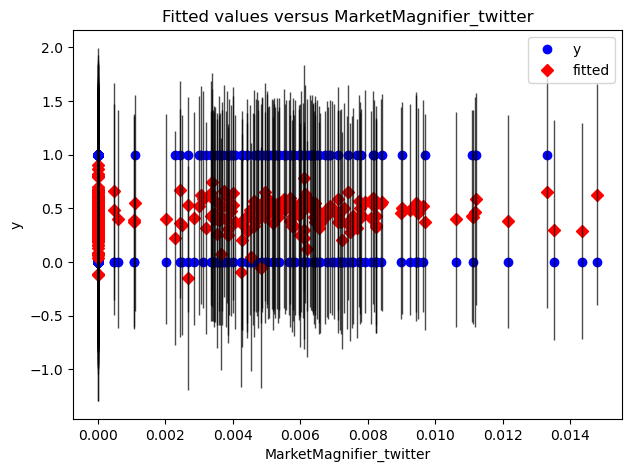

In [192]:
fig = sm.graphics.plot_fit(lm, "MarketMagnifier_twitter")
fig.tight_layout(pad=1.0)

In [190]:
# fig = sm.graphics.influence_plot(lm, criterion="cooks")
# fig.tight_layout(pad=1.0)

## Seperate Analysis of Short Term and Long Term Analysts

In [ ]:
# Analyzing short term and long term words
all_words_longterm = strip_all_words(df_long_term, stop)
all_words_longterm = all_words_longterm.explode().dropna()
all_words_longterm = all_words_longterm.replace("", np.nan,regex=True).dropna()
counts_longterm = all_words_longterm.value_counts()

all_words_shorterm = strip_all_words(df_short_term, stop)
all_words_shorterm = all_words_shorterm.explode().dropna()
all_words_shorterm = all_words_shorterm.replace("", np.nan,regex=True).dropna()
counts_shorterm = all_words_shorterm.value_counts()

nlp_words_long=nltk.FreqDist(all_words_longterm)
nlp_words_short=nltk.FreqDist(all_words_shorterm)

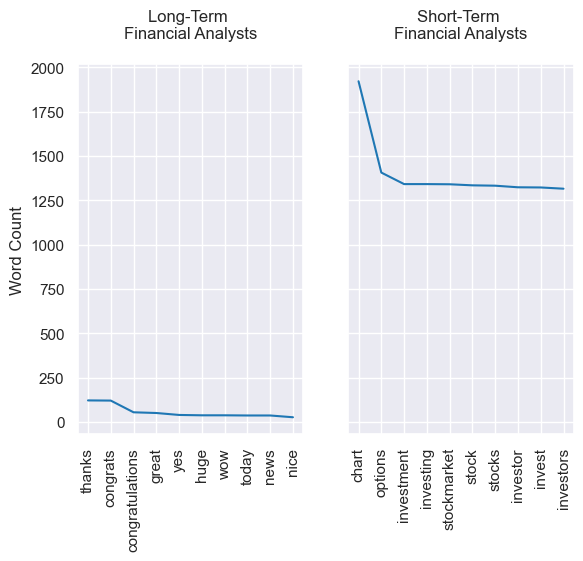

In [56]:
# Top 10 short and Long Term
how_many_samples = 10
sample_long = counts_longterm[0:how_many_samples]
sample_short = counts_shorterm[0:how_many_samples]
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
f = sns.lineplot(x = sample_long.index, y = sample_long, ax=ax1)
g = sns.lineplot(x = sample_short.index, y = sample_short, ax=ax2)
f.set(ylabel ="Word Count", title ='Long-Term \nFinancial Analysts\n')
g.set(ylabel ="Word Count", title ='Short-Term \nFinancial Analysts\n')
sns.set_style('darkgrid')
f.tick_params(axis='x', rotation=90)
g.tick_params(axis='x', rotation=90)

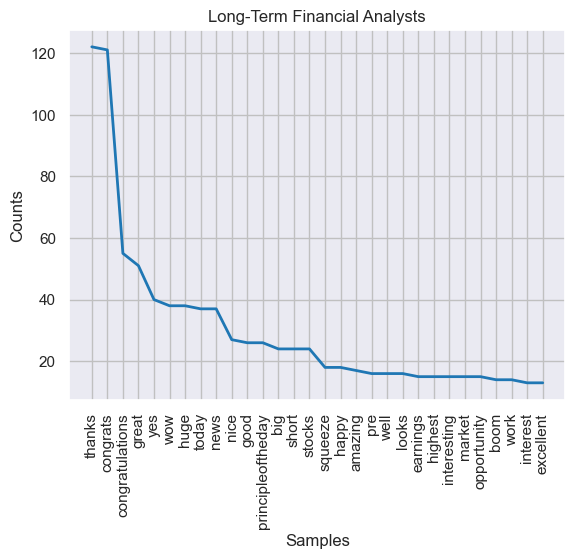

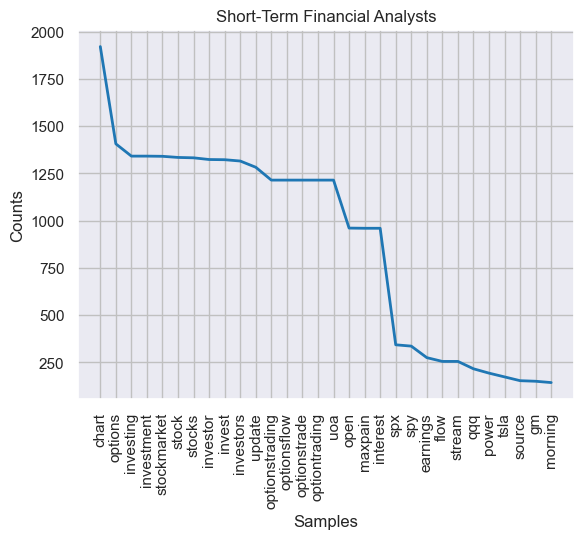

<AxesSubplot:title={'center':'Short-Term Financial Analysts'}, xlabel='Samples', ylabel='Counts'>

In [57]:
nlp_words_long.plot(30, title='Long-Term Financial Analysts')
nlp_words_short.plot(30, title='Short-Term Financial Analysts')

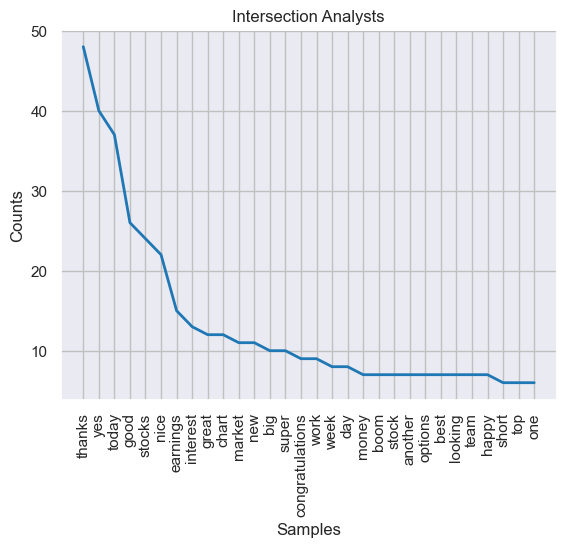

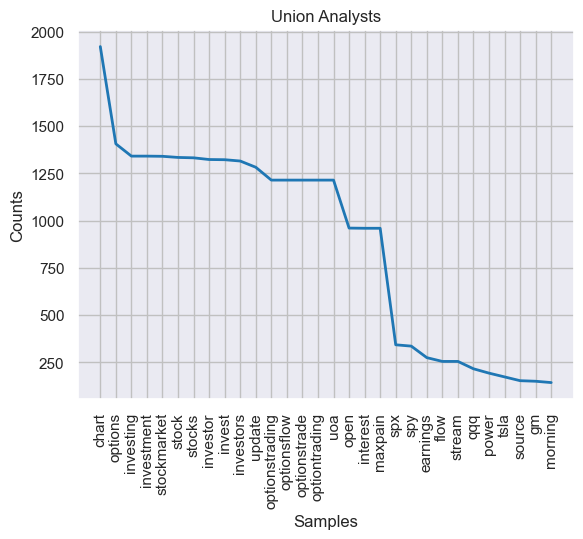

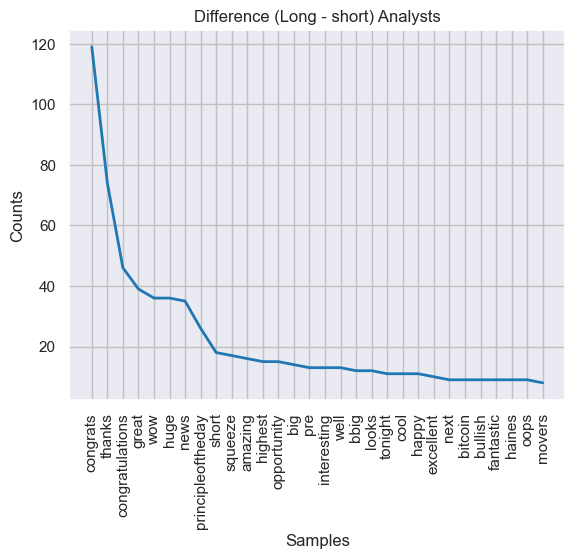

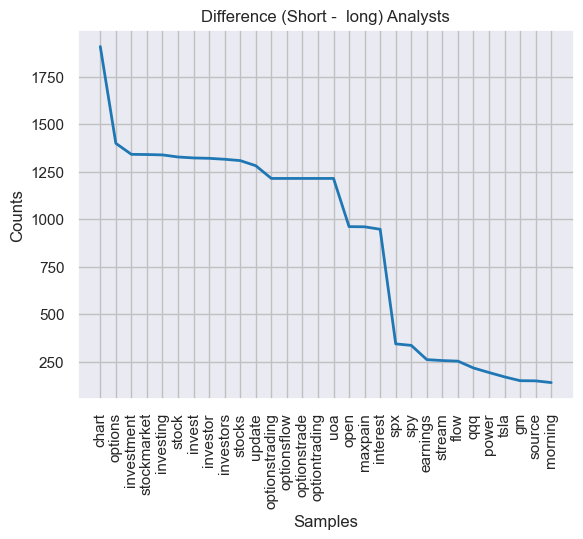

<AxesSubplot:title={'center':'Difference (Short -  long) Analysts'}, xlabel='Samples', ylabel='Counts'>

In [126]:
df_short_intersect = nlp_words_long & nlp_words_short
df_short_union = nlp_words_long | nlp_words_short
df_short_difference_long = nlp_words_long - nlp_words_short
df_short_difference_short = nlp_words_short - nlp_words_long

df_short_intersect.plot(30, title='Intersection Analysts')
df_short_union.plot(30, title='Union Analysts')
df_short_difference_long.plot(30, title='Difference (Long - short) Analysts')
df_short_difference_short.plot(30, title='Difference (Short -  long) Analysts')